# Importing all the necessary libraries 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, Rotate, GaussianBlur, Cutout
)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lego-minifigures-classification/metadata.csv
/kaggle/input/lego-minifigures-classification/LICENSE
/kaggle/input/lego-minifigures-classification/index.csv
/kaggle/input/lego-minifigures-classification/harry-potter/0002/006.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/013.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/008.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/002.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/003.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/005.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/007.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/009.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/011.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/012.jpg
/kaggle/input/lego-minifigures-classification/harry-potter/0002/004.jpg
/kaggle/input/lego-minifigures-classifi

In [5]:
tf.random.set_seed(0)

# 1. Read the dataset

In [6]:
df = pd.read_csv('../input/lego-minifigures-classification/index.csv')
df.describe()

,Unnamed: 0,class_id
count,352.000000,352.000000
mean,175.500000,16.656250
std,101.757883,9.029456
min,0.000000,1.000000
25%,87.750000,8.000000
50%,175.500000,18.000000
75%,263.250000,24.250000
max,351.000000,31.000000


In [7]:
df.head()

,Unnamed: 0,path,class_id,train-valid
0,0,marvel/0001/001.jpg,1,train
1,1,marvel/0001/002.jpg,1,valid
2,2,marvel/0001/003.jpg,1,train
3,3,marvel/0001/004.jpg,1,train
4,4,marvel/0001/005.jpg,1,train


# 2. Splitting the dataset into training and validation sets
We can see that:
* path - path to the image
* class_id - class of the image
* train-valid - indication of training and validation data
We use train-valid to split the dataset into training and validation set

In [8]:
train_set = df[df['train-valid'] == 'train']
valid_set = df[df['train-valid'] == 'valid']

An overview of the training set

In [9]:
train_set

,Unnamed: 0,path,class_id,train-valid
0,0,marvel/0001/001.jpg,1,train
2,2,marvel/0001/003.jpg,1,train
3,3,marvel/0001/004.jpg,1,train
4,4,marvel/0001/005.jpg,1,train
6,6,marvel/0001/007.jpg,1,train
...,...,...,...,...
341,341,marvel/0017/002.jpg,31,train
342,342,marvel/0017/003.jpg,31,train
343,343,marvel/0017/004.jpg,31,train
344,344,marvel/0017/005.jpg,31,train


An overview of the validation set

In [10]:
valid_set

,Unnamed: 0,path,class_id,train-valid
1,1,marvel/0001/002.jpg,1,valid
5,5,marvel/0001/006.jpg,1,valid
7,7,marvel/0001/008.jpg,1,valid
8,8,marvel/0001/009.jpg,1,valid
9,9,marvel/0001/010.jpg,1,valid
...,...,...,...,...
347,347,marvel/0017/008.jpg,31,valid
348,348,marvel/0017/009.jpg,31,valid
349,349,marvel/0017/010.jpg,31,valid
350,350,marvel/0017/011.jpg,31,valid


Creating the train paths list to hold all the image paths to training images

In [11]:
train_paths = []
for path in train_set['path'].values:
    train_paths.append(os.path.join('../input/lego-minifigures-classification/',path))
train_paths

['../input/lego-minifigures-classification/marvel/0001/001.jpg',
 '../input/lego-minifigures-classification/marvel/0001/003.jpg',
 '../input/lego-minifigures-classification/marvel/0001/004.jpg',
 '../input/lego-minifigures-classification/marvel/0001/005.jpg',
 '../input/lego-minifigures-classification/marvel/0001/007.jpg',
 '../input/lego-minifigures-classification/marvel/0002/001.jpg',
 '../input/lego-minifigures-classification/marvel/0002/003.jpg',
 '../input/lego-minifigures-classification/marvel/0002/004.jpg',
 '../input/lego-minifigures-classification/marvel/0002/005.jpg',
 '../input/lego-minifigures-classification/marvel/0002/007.jpg',
 '../input/lego-minifigures-classification/marvel/0003/001.jpg',
 '../input/lego-minifigures-classification/marvel/0003/003.jpg',
 '../input/lego-minifigures-classification/marvel/0003/004.jpg',
 '../input/lego-minifigures-classification/marvel/0003/005.jpg',
 '../input/lego-minifigures-classification/marvel/0003/007.jpg',
 '../input/lego-minifigur

Creating the valid paths list to hold all the image paths to validation images

In [12]:
valid_paths = []
for path in valid_set['path'].values:
    valid_paths.append(os.path.join('../input/lego-minifigures-classification/',path))
valid_paths

['../input/lego-minifigures-classification/marvel/0001/002.jpg',
 '../input/lego-minifigures-classification/marvel/0001/006.jpg',
 '../input/lego-minifigures-classification/marvel/0001/008.jpg',
 '../input/lego-minifigures-classification/marvel/0001/009.jpg',
 '../input/lego-minifigures-classification/marvel/0001/010.jpg',
 '../input/lego-minifigures-classification/marvel/0002/002.jpg',
 '../input/lego-minifigures-classification/marvel/0002/006.jpg',
 '../input/lego-minifigures-classification/marvel/0002/008.jpg',
 '../input/lego-minifigures-classification/marvel/0002/009.jpg',
 '../input/lego-minifigures-classification/marvel/0002/010.jpg',
 '../input/lego-minifigures-classification/marvel/0003/002.jpg',
 '../input/lego-minifigures-classification/marvel/0003/006.jpg',
 '../input/lego-minifigures-classification/marvel/0003/008.jpg',
 '../input/lego-minifigures-classification/marvel/0003/009.jpg',
 '../input/lego-minifigures-classification/marvel/0003/010.jpg',
 '../input/lego-minifigur

Creating the train labels list to hold all the corresponding classes of training images

In [13]:
train_labels = train_set['class_id'].values
train_labels

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  8,  8,  9,  9,  5,  6,  7, 10, 10,  8,  8,  8,  8,
        8,  9,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12,
       13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16,
       16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19,
       19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21,
       22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27,
       27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29,
       30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31])

Creating the valid labels list to hold all the corresponding classes of validation images

In [14]:
valid_labels = valid_set['class_id'].values
valid_labels

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  9, 10,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 11, 12, 13,
       14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18,
       18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26,
       26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29,
       29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31])

Getting the number of classes of images from the metadata.csv file

In [15]:
dfmeta = pd.read_csv('../input/lego-minifigures-classification/metadata.csv')
no_of_classes = dfmeta.shape[0]
no_of_classes

31

# 3. Creating a custom data generator for our dataset.
For more information and a detailed explanation of the concept, do check out these amazing blog posts:
* https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c 
* https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

Image augmentations are also performed by the data generator using the albumentations package.
* https://albumentations.ai/docs/getting_started/image_augmentation/

We'll be using augmentations.transforms for performing augmentations like flip, rotation, blur, contrast, brightness, blur
* https://albumentations.ai/docs/api_reference/augmentations/transforms/

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, paths, labels = None, image_size = (512,512), batch_size = 32, num_classes = None, shuffle = False, transforms = False):
        self.paths = paths
        self.labels = labels
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.transforms = transforms
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.paths)//self.batch_size
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        X, y = self.__get_data(indices)
        return X, y
    
    def __get_data(self, indices):
        batch = [self.paths[k] for k in indices]
        images = []
        for i in range(self.batch_size):
            img = cv2.imread(batch[i])
            img = cv2.resize(img, self.image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transforms:
                img = self.transforms(image = img)['image']
            img = img/255.0
            images.append(img)
        labels = [self.labels[k] - 1 for k in indices]
        return np.array(images), np.array(labels)       
    
    # this function is called at the end of every epoch
    def on_epoch_end(self):
        self.indices = np.arange(len(self.paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
            
# function to carry out image augmentation
def transforms():
    return Compose([
                    Rotate(limit=40),
                    HorizontalFlip(p=0.5),
                    RandomBrightness(limit=0.2,p=0.5),
                    RandomContrast(limit=0.2, p=0.5),
                    JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
                    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
                    GaussianBlur(blur_limit=(3, 7), always_apply=False, p=0.5),
                    Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5)
                    ])
    

In [17]:
IMAGE_SIZE = (512,512)

# 4. Specifying the train and validation data generators

In [18]:
train_generator = DataGenerator(train_paths,
                               train_labels,
                               image_size = IMAGE_SIZE,
                               batch_size = 4,
                               num_classes = no_of_classes,
                               shuffle = True,
                               transforms = transforms())

In [19]:
valid_generator = DataGenerator(valid_paths,
                               valid_labels,
                               image_size = IMAGE_SIZE,
                               batch_size = 1,
                               num_classes = no_of_classes,
                               shuffle = False)

# 5. Plotting images from the train and validation sets

Plotting a few images from the training set

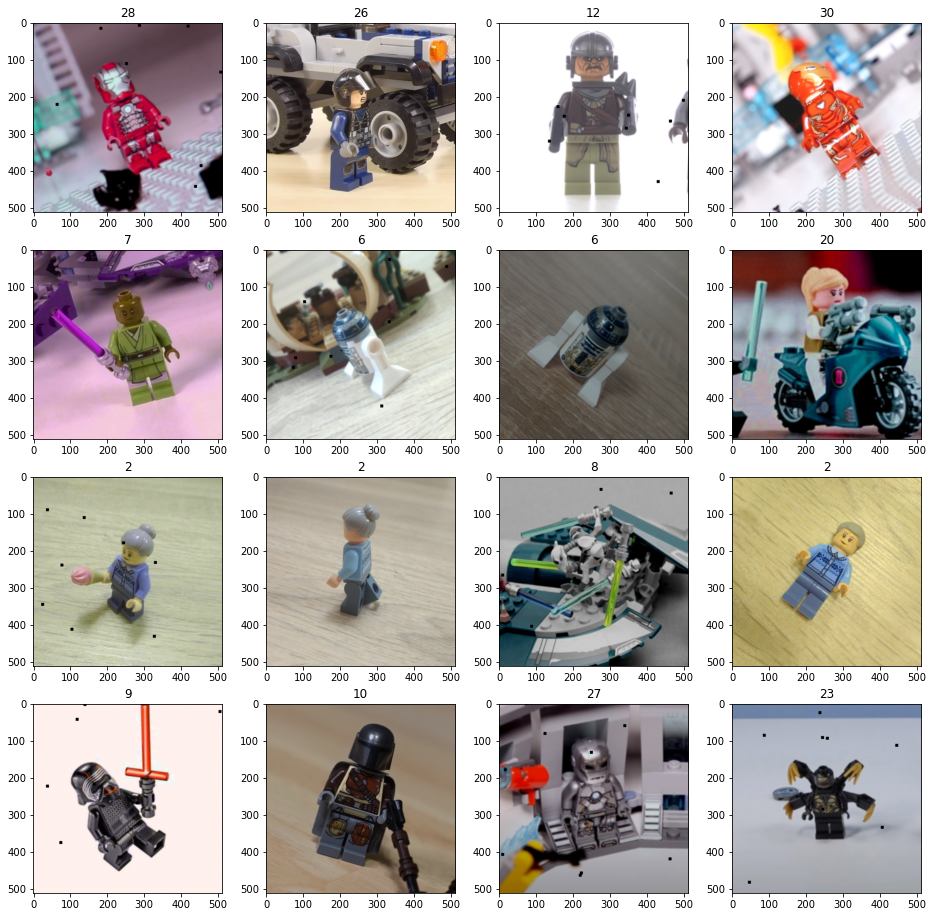

In [20]:
plt.figure(figsize = (16,16))
for row in range(4):
    images, labels = train_generator[row]
    for col in range(4):
        plt.subplot(4,4,(row * 4 + col) + 1)
        plt.imshow(images[col])
        plt.title(labels[col])

Plotting a few images from the validation set

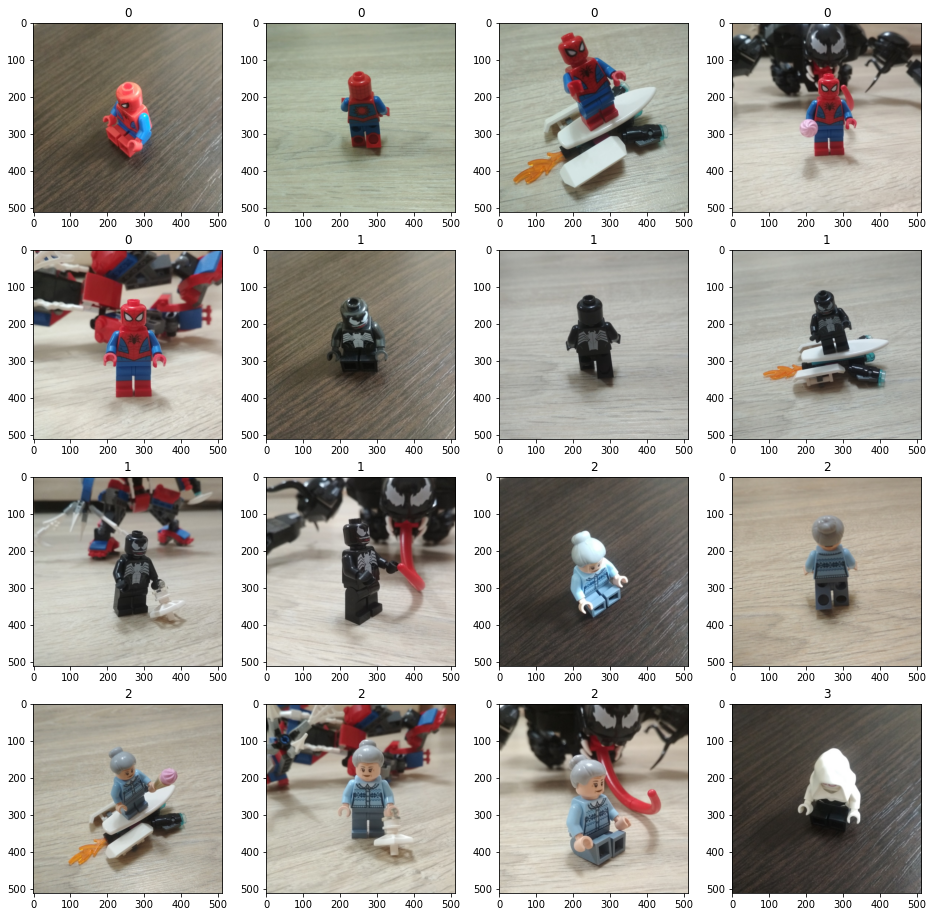

In [21]:
plt.figure(figsize = (16,16))
for i in range(16):
    image, label = valid_generator[i]
    plt.subplot(4,4,i + 1)
    plt.imshow(image[0])
    plt.title(label[0])

# Pre Trained Models in keras, tensorflow

Keras has a wide range of pre trained models to choose from and implement in our code.
To read about all the pre trained models available in keras and their usage refer:
https://keras.rstudio.com/articles/applications.html

# 6. Creating and training a VGG16 model

We will be using the VGG16 model which is built for image classification. It was developed by Visual Graphics Group (VGG) at Oxford and described in the "Very Deep Convolutional Networks for Large-Scale Image Recognition" paper.

Some useful links:
* https://keras.io/api/applications/vgg/
* https://keras.rstudio.com/reference/application_vgg.html
* https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [22]:
def create_model(input_shape):
    # initialize the base model as VGG16 model with input shape as (512,512,3)
    base_model = VGG16(input_shape = input_shape,
                       include_top = False,
                       weights = 'imagenet')

    # we do not have to train all of the layers
    for layer in base_model.layers:
        layer.trainable = False
        
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(no_of_classes, activation = 'softmax')(x)
    
    return models.Model(base_model.input,x)

In [23]:
model = create_model((512,512,3))

58892288/58889256 [==============================] - 1s 0us/step


In [24]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

Adding some callback functions from the tensorflow library
* EarlyStopping - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
* ModelCheckpoint - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [25]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               mode = 'min',
                               restore_best_weights = True)

In [26]:
# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = 'val_loss',
                             verbose = 1,
                             mode = 'min', 
                             save_best_only = True)

In [27]:
EPOCHS = 50

In [28]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = EPOCHS,
                    steps_per_epoch = len(train_generator),
                    validation_steps = len(valid_generator),
                    callbacks = [early_stopping, checkpoint])

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 5.6068 - accuracy: 0.0444
Epoch 00001: val_loss improved from inf to 3.41800, saving model to best_model.hdf5
45/45 [==============================] - 10s 213ms/step - loss: 5.6068 - accuracy: 0.0444 - val_loss: 3.4180 - val_accuracy: 0.0588
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 3.4032 - accuracy: 0.0611
Epoch 00002: val_loss did not improve from 3.41800
45/45 [==============================] - 7s 158ms/step - loss: 3.4032 - accuracy: 0.0611 - val_loss: 3.4495 - val_accuracy: 0.0529
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 3.3747 - accuracy: 0.0833
Epoch 00003: val_loss improved from 3.41800 to 3.28483, saving model to best_model.hdf5
45/45 [==============================] - 10s 229ms/step - loss: 3.3747 - accuracy: 0.0833 - val_loss: 3.2848 - val_accuracy: 0.0706
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 3.2296 - accuracy: 0.1111
Epoch 

# 7. Evaluating the model

In [29]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)    

Plotting the training v/s validation accuracy and training v/s validation loss

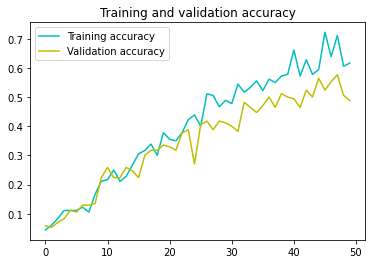

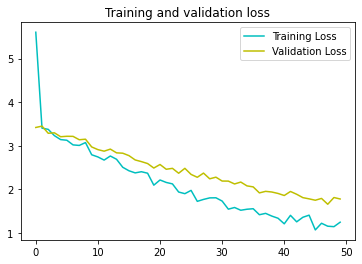

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'c-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'c-', label='Training Loss')
plt.plot(epochs, val_loss, 'y-', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Load the best trained model and check its summary

In [31]:
# load the best saved model as a new model
new_model = models.load_model('best_model.hdf5')

# Check its architecture
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)    

In [32]:
# Evaluate the restored model

actual_y = []
pred_y = []

for image, label in valid_generator:
    pred_y.extend(new_model.predict(image).argmax(axis = 1))
    actual_y.extend(label)

In [33]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(actual_y, pred_y)
print('Accuracy: {:5.2f}%'.format(100*acc))

Accuracy: 57.65%
